# Forecast

In [1]:
import pyaiutils as pai
import pandas as pd

In [2]:
DATA_DIR = './downloads/pre-processed'

In [3]:
from tensorflow.keras import backend as K


class Metric:
    """Class with the metrics to evaluate the forecast
    """

    @staticmethod
    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    @staticmethod
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    @staticmethod
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
import tensorflow as tf
import numpy as np
import sklearn
import pickle


class Model:
    
    def __init__(self, model: str, scaler: str):
        """Class for the neural network model.
        
        Parameters
        ----------
        model : str
            Path to the model file
        scaler : str
            Path to the scaler file
        """
        self._model = self._load_model(model)
        self._scaler = self._load_scaler(scaler)
        
    def _load_model(self, path: str) -> tf.keras.Model:
        """Load the model
        
        Parameters
        ----------
        path : str
            Path to the model file

        Returns
        -------
        tf.keras.Model
            Keras model
        """
        try:
            return tf.keras.models.load_model(
                path,
                custom_objects = {
                    'precision_m': Metric.precision_m,
                    'recall_m': Metric.recall_m,
                    'f1_m': Metric.f1_m
                }
            )
        except OSError:
            raise OSError(f'Model not found in {path}')
    
    def _load_scaler(self, path: str):
        """Load the scaler
        
        Parameters
        ----------
        path : str
            Path to the scaler file

        Returns
        -------
        sklearn.preprocessing.*
            Scikit-learn scaler
        """
        try:
            with open(path, 'rb') as f:
                return pickle.load(f)
        except FileNotFoundError:
            raise FileNotFoundError(f'Scaler not found in {path}')
        
    def _transform(self) -> None:
        """Abstract method
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray):
        """Predict from x
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x forecast result
        """
        return self._model.predict(self._transform(x))
    
    def evaluate(
        self,
        x_test: np.ndarray,
        y_test: np.ndarray,
        class_names: [str],
        path: str = None
    ) -> None:
        y_pred = self.predict(x_test)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        pai.plot_graphics(y_true, y_pred, class_names=class_names, save_path=path)
        display(pai.get_metrics(y_true, y_pred, class_names=class_names, save_path=path))

In [5]:
class MLP(Model):
    def _transform(self, x: np.ndarray) -> np.ndarray:
        """x scale
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x scaled
        """
        return self._scaler.transform(x)

In [6]:
class CNN(Model):
    def _transform(self, x: np.ndarray) -> np.ndarray:
        """x scale
        
        Parameters
        ----------
        x : np.ndarray
            Array expected for model entry

        Returns
        -------
        np.ndarray
            x scaled
        """
        x = self._scaler.transform(x)
        return np.reshape(x, (x.shape[0], 1, x.shape[1]))
         

### Examples

COVID/NÃO-COVID

Expected entries for the model (In expected order)

In [7]:
symptoms = [
    'FEBRE', # Febre
    'TOSSE', # Tosse
    'GARGANTA', # Dor de garganta
    'DISPNEIA', # Dispneia // falta de ar
    'DESC_RESP', # Desconforto respiratório
    'SATURACAO', # Saturação de O2 abaixo de 95%
    'DIARREIA', # Diarreia
#     'VOMITO', # Vômito
]
comorbidities = [
    'PUERPERA', # Puérpera // mulher que deu à luz há bem pouco tempo.
    'CARDIOPATI', # Doença cardiovascular // coração
#     'HEMATOLOGI', # Componentes do sangue
    'SIND_DOWN', # Síndrome de Down
    'HEPATICA', # Doença hepática // fígado
#     'ASMA', # Asma
#     'DIABETES', Diabetes
    'NEUROLOGIC', # Doença neurológica // sistema nervoso
    'PNEUMOPATI', # Pneumopatia // pulmão
    'IMUNODEPRE', # Imunodeficiência ou Imunodepressão // sistema imunológico
    'RENAL', # Doença renal
    'OBESIDADE', # Obesidade
]
x_cols = [
    *symptoms,
    *comorbidities,
    'Sexo', # Sexo
    'NU_IDADE_N', # Idade
]
y_cols = ['CLASSI_FIN'] # Classificação

|Sintomas|Comorbidades|CS_SEXO|NU_IDADE_N|CLASSI_FIN|
|--|--|--|--|--|
|0. NaN|0. NaN|||
|1. Sim|1. Sim|1: Masculino||0. Não Covid|
|2. Não|2. Não|2: Feminino||1. Covid|
|9. Ignorado|9. Ignorado||||

Open dataset

In [8]:
df = pd.read_csv(f'{DATA_DIR}/01_07-05_10-wcoords.csv', low_memory=False)

Mapping attributes expected by the model

In [9]:
# Data de Nascimento
# Gestante
# Gestante de alto risco
# Idade em anos
# Sem morbidades
mapping = {
    'FEBRE': ['Febre'],
    'TOSSE': ['Tosse'],
    'GARGANTA': [
        'Dor de garganta',
        'Exsudato faríngeo',
    ],
    'DISPNEIA': ['Dispneia/Taquipneia'],
    'DESC_RESP': ['Dificuldade de respirar'],
    'SATURACAO': [],
    'DIARREIA': ['Diarreia'],
    'VOMITO': ['Náusea/vômitos'],
    'PUERPERA': [],
    'CARDIOPATI': ['Doença cardiovascular, incluindo hipertensão'],
    'HEMATOLOGI': ['Neoplasia (tumor sólido ou hematológico)'],
    'SIND_DOWN': [
        'Portador de alterações cromossômicas',
        'Portador de doenças cromossômicas',
    ],
    'HEPATICA': ['Doença hepática'],
    'ASMA': [],
    'DIABETES': ['Diabetes'],
    'NEUROLOGIC': [
        'Doença neurológica crônica ou neuromuscular',
        'Irritabilidade/confusão',
    ],
    'PNEUMOPATI': [
        'Alteração de ausculta pulmonar',
        'Doença Respiratória crônica',
        'Doença respiratória crônica',
    ],
    'IMUNODEPRE': [
        'Imunodeficiência',
        'Imunossupressão',
        'Infecção pelo HIV',
    ],
    'RENAL': ['Doença renal'],
    'OBESIDADE': [],
}
# [c for c in df.columns][70:]

In [10]:
def _map(row: pd.Series, cols: [str]) -> int:
    return 1 if row[cols].any() else 0

for col in mapping:
    cols = mapping[col]
    df[col] = df.apply(lambda r: _map(r, cols), axis=1)
    df = df.drop(columns=cols)

Considering the cases without morbidities

In [11]:
f1 = df['Sem morbidades'] == 1
f2 = ~df[comorbidities].any(axis=1)
df.loc[f1&f2, comorbidities] = 2

Age mapping

In [12]:
def age(row: pd.Series):
    try:
        _age = 2020 - pd.to_datetime(row['Data de nascimento']).year
        if _age < 0:
            raise ValueError
    except:
        _age = int(float(row['Idade em anos']))
        if _age < 0:
            _age = np.nan
    finally:
        return _age

df['NU_IDADE_N'] = df.apply(age, axis=1)
df = df.drop(columns=['Data de nascimento', 'Idade em anos'])

Replace 2 to 0 (Negative)

In [13]:
df['CLASSI_FIN'] = df['RESULTADO'].replace({2.0: 0.0})

Get only valid tuples

In [14]:
f1 = df['CLASSI_FIN'].isin([0,1])
f2 = ~df['NU_IDADE_N'].isnull()
df = df[f1&f2]

Save x,y

In [15]:
df[x_cols].to_csv(f'{DATA_DIR}/01_07-05_10-xcols.csv', index=False)
df[y_cols].to_csv(f'{DATA_DIR}/01_07-05_10-ycols.csv', index=False)

- pm: path to the model
- ps: path to the scaler

In [16]:
# pm = './models/mlp_covid.h5'
# ps = './scalers/scaler_covid.pkl'
# covid = MLP(model=pm, scaler=ps)

pm = './models/cnn_covid.h5'
ps = './scalers/scaler_covid.pkl'
covid = CNN(model=pm, scaler=ps)

Prediction

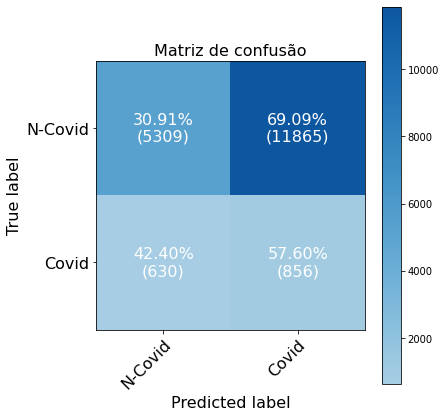

None

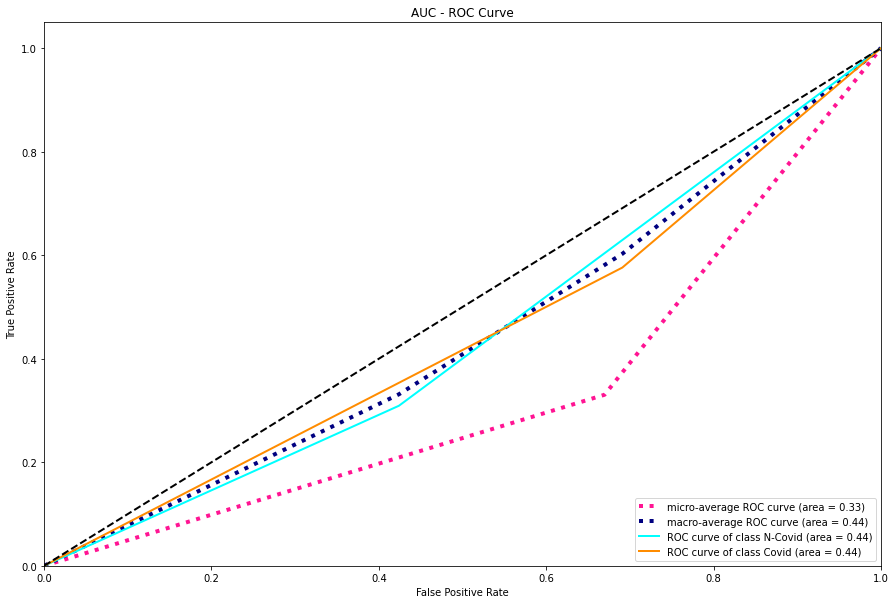

None

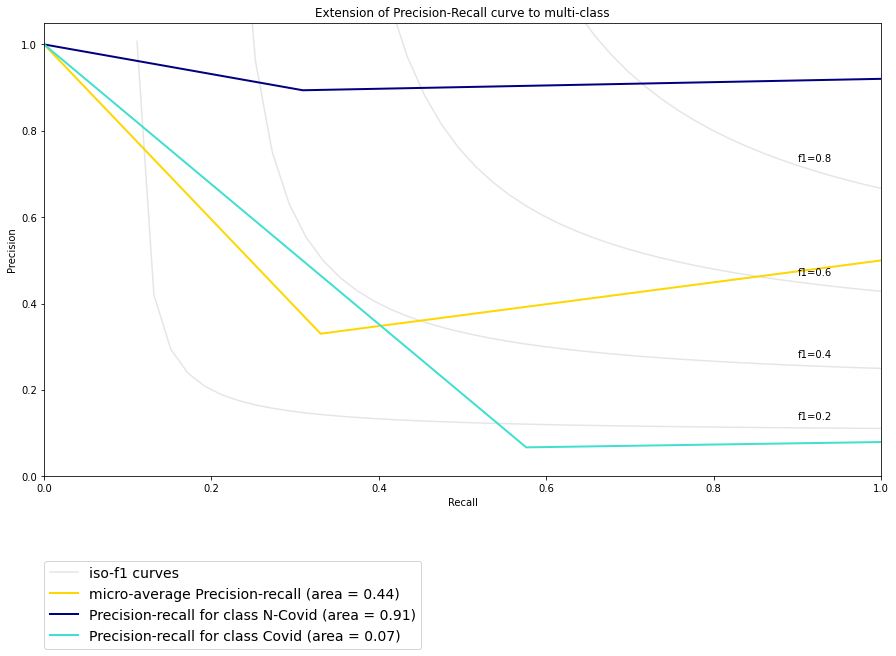

None

,Classes,F1,ROC AUC,PRC AUC,Precision,Recall,Specificity,Accuracy
0,N-Covid,0.46,0.44,0.91,0.89,0.31,0.58,0.33
1,Covid,0.12,0.44,0.07,0.07,0.58,0.31,0.33
2,Média,0.29,0.44,0.49,0.48,0.44,0.44,0.33


In [17]:
covid.evaluate(
    x_test=df[x_cols],
    y_test=tf.keras.utils.to_categorical(df[y_cols]),
    class_names=['N-Covid', 'Covid'],
    path='./results'
)